# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [159]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score, auc
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder

In [3]:
#my import
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import set_config
set_config(display='diagram')

**_Моя функция для создания файла ответов, 
видимо можно лучше, но пока неохото разбираться. 
Если знаете более короткую реализацию, можете поделится в отзыве._**

In [44]:
def create_csv(estimator, predict, name="submit", cv_train = None, cv_test = None):
    import csv
    with open(f'D:\\{name}.csv', 'w') as f:
        fieldnames = ['PassengerId', 'Survived']
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()

        for i, elem in enumerate(predict, 892):
            f.write(f"{i},{elem}\n")
            
    print(f"COMMENT FOR KAGGLE")
    print("============")
    print(estimator)
    print(features)
    print("CV on X_train: ", cv_train)
    print("CV on X_test: ", cv_test)

## Part 1: Titanic survival prediction
---

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [5]:
PATH = "./data/"

In [6]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))

In [7]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [8]:
# How many females and males are there in the dataset?
# Смотрим сколько мужчин (male) и женщин (female) в датасете.
data.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [9]:
# What about the survived (1) passengers?
# Смотрим количество погибших (0) и выживших (1) 
data.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

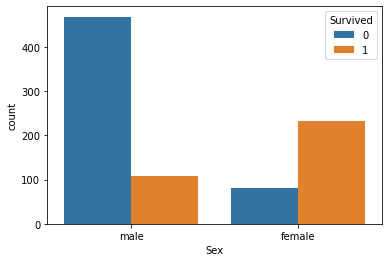

In [10]:
# Is there any relationship between the gender and the survival? Part 1. 
# Да есть мужчины с меньшей вероятностью выживают, 
# даже можно сказать с большей вероятностью погибают.

sns.countplot(x="Sex", hue="Survived", data=data);

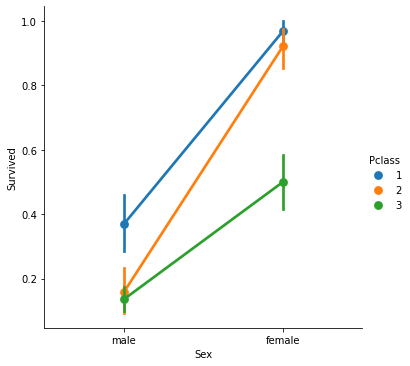

In [11]:
# Is there any relationship between the gender and the survival? Part 2.
# зависимости между полом, выживаемостью и заодно классом каюты пассажира
# (очень крутой на мой взгляд катплот, не удержался стырить его из примеров seaborn)
sns.catplot(x="Sex", y="Survived", hue="Pclass",  kind="point",  data=data);

#### Ещё раз данные и выводы

**_How many females and males are there in the dataset?_**
- male      577
- female    314

**_What about the survived passengers?_**
- Not Survived    549
- Survived     342

**_Is there any relationship between the gender and the survival?_**

_Да зависимость между полом и выживаемости прослеживается напрямую.
Врятли кто-то будет спорить, что по всем данным у женщин шанс выжить выходит куда выше. Связанно это конечно же с несколькими факторами, один из которых это первоочерёдная эвакуация женщин и детей, о чём собсвтенно и написано даже в википедии._

["A disproportionate number of men were left aboard because of a "women and children first" protocol for loading lifeboats"](https://en.wikipedia.org/wiki/Titanic)

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

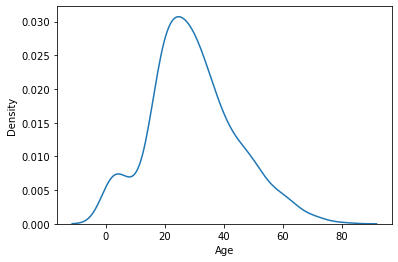

In [12]:
# Plot age distribution of the passengers. v1
# Возраст сам по себе
sns.kdeplot(x="Age", 
            data=data,
           );

In [13]:
# Plot age distribution of the passengers. v2
# Я не смог выбрать какой грфик распределения забахать, с линиями выглядит круче, 
# но на олдскульном лучше видно "выбросы" чтоле

def old_school_age_distribution():
    data.Age.hist(bins=30, legend=True, alpha=0.6)
    plt.title('Distribution Of The Passengers')
    plt.xlabel('Age')
    plt.ylabel("Frequency");
    
# old_school_age_distribution() # РАСКОМЕНТРУЙ МЕНЯ ЕСЛИ ХОЧЕШЬ ОЛДСКУЛА!

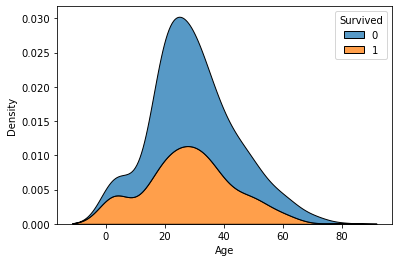

In [14]:
# Строим график зависимости возвраста и выживания

sns.kdeplot(x="Age", 
            hue="Survived", 
            multiple="stack",
            data=data,
           );

In [15]:
# Всё тот же второй вариант с подробностями чтоле

def old_school_age_survived_distribution():
    data.groupby('Survived').Age.hist(bins=30, 
                                  legend=True, 
                                  alpha=0.6)
    plt.title('Age Distributions Differ For Survived And Deceased Passengers')
    plt.xlabel('Age')
    plt.ylabel("Frequency of Survived");
# old_school_age_survived_distribution() # РАСКОМЕНТРУЙ МЕНЯ ЕСЛИ ХОЧЕШЬ ОЛДСКУЛА!

### Снова итоги и рассуждения

_Распределение почти правильное, т.е. в основном выживали люди молодого возраста от 20 до 40 лет. Есть правда большая группа от 0 до 10 лет, что подтверждает гипотезу о том, что среди выживших много женщин и детей, потому что их спасали в первую очередь._


**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

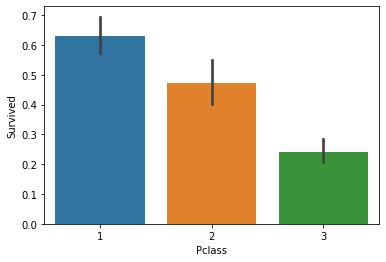

In [16]:
## Explore "passenger class" and "embarked" features. 
## What class was "the safest"?
# Очевидно что пассажиры первого класса были в лучшем положении чем пассажиры других классов.
# График это подтверждает
sns.barplot(x="Pclass", y="Survived", data=data);

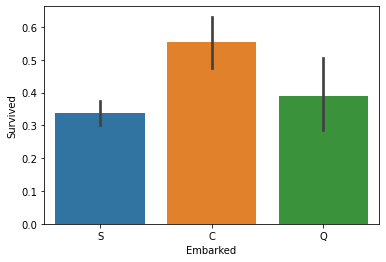

In [17]:
# Как видим больше всего выживших севших в порту C = Cherbourg, это второй порт в котором Титаник забирал людей.
sns.barplot(x="Embarked", y="Survived", data=data);

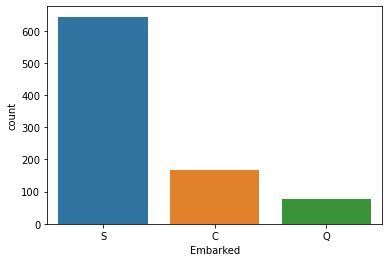

In [18]:
# И это при том, что как видим большая часть пассажиров зашла на борт в первом порту S = Southampton 
sns.countplot(x="Embarked", data=data);

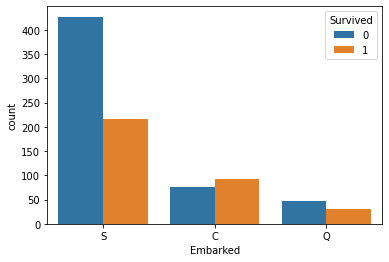

In [19]:
# Смотрим и видим, что разгадка проста. Т.к. людей в порту S зашло очень много, 
# то количество выживших из этого порта не так велико в отношении к погибшим, 
# как в других портах.
sns.countplot(x="Embarked", hue="Survived", data=data);

#### Итоги

В общем класс пассажира таки влияет на вероятность выжить, на мой взгляд это связано с расположением их кают на корабле, палубы с более лучшими каютами находятся сверху, и соответственно быстрее могут эвакуироваться. Что в принципе и было сделано, а для отсутствия паники капитан корабля руководил эвакуацией, людей держали в неведении, говоря об эвакуации как мере предостороженности. https://ru.wikipedia.org/wiki/Крушение_«Титаника»

То, в каком порту пасажир сел на судно так же влияет, хоть и не так сильно. Как я писал выше, вероятность выжить от порта  распределилась так из-за сильного расхождения в количестве людей с каждого порта. 

Я было подумал, что некоторые пассажиры просто сходили с судна в промежуточных портах, но пришлось обломаться, т.к. база включает только тех людей которые находились на корабле в момент столкновения с айсбергом. 

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [20]:
## Пришло время строить модель
from tabulate import tabulate


# Расчехляем приём из прошлых занятий 
# для построения крутых таблиц по поиску нулевых значений
# оформим это дело в функцию, она нам еще понадобится, наверное.
# Почти круто! Косячат три фичи, при чем некоторые довольно сильно! 
# И да это я про тебя "Cabin"!
def null_table(data):
    top = 15
    print(tabulate(
        sorted(list(zip(data.columns, data.isnull().sum(), 
                        data.isnull().sum() / data.shape[0] * 100)), 
               key=lambda x: -x[2])[:top], 
        headers=['col_name', 'null_cnt', 'null_perc']))
    
null_table(data)

col_name      null_cnt    null_perc
----------  ----------  -----------
Cabin              687    77.1044
Age                177    19.8653
Embarked             2     0.224467
Survived             0     0
Pclass               0     0
Name                 0     0
Sex                  0     0
SibSp                0     0
Parch                0     0
Ticket               0     0
Fare                 0     0


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

#### Мыслишки

Думаю стоит убрать параметр Cabin т.к. слишком велик процент неизвестных значений, будет довольно сложно их восполнить или вычислить. 
_Дополняя всё это через время, могу сказать что в принципе этот параметр можно таки использовать. Наличие параметра как такового, а не нан, практически кричит нам о том что человек выжил. **(графики в следующей ячейке это подтверждают)** Забавно, но мои модели с этим параметром точнее не стали, хотя на графиках всё красиво. Поэтому не ожидайте что я буду его использовать._ 

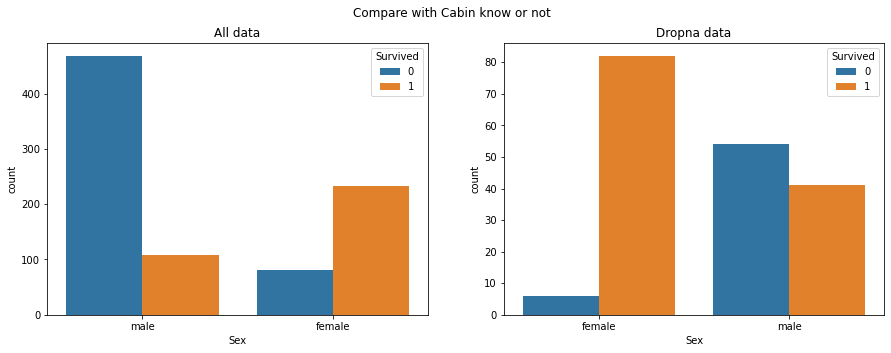

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
fig.suptitle('Compare with Cabin know or not')

sns.countplot(ax=axes[0], x="Sex", hue="Survived", data=data);
axes[0].set_title("All data");

sns.countplot(ax=axes[1], x="Sex", hue="Survived", data=data.dropna());
axes[1].set_title("Dropna data");


Продолжаем.

Для Age можно вычислить среднее, но мне кажется это очень исказит результаты вычислений, поэтому сложно.
_В общем-то я был прав, и это было ошибкой. Покажу на радужных графиках, зря я чтоле seaborn тискал?_

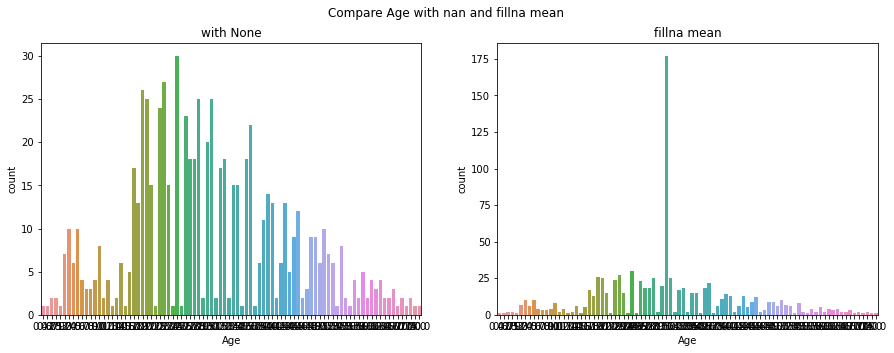

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
fig.suptitle('Compare Age with nan and fillna mean')

sns.countplot(ax=axes[0], x="Age", data=data);
axes[0].set_title("with None");

temp = data.copy()
temp.Age = temp.Age.fillna(temp.Age.mean())
sns.countplot(ax=axes[1], x="Age", data=temp);
axes[1].set_title("fillna mean");

Как видим, заполнять возраст средним значением по колонке дико плохая идея.
В принципе, возраст можно было бы заполнить на основе данных имени и других фич, например есть ли приставка mrs, и есть ли дети. Впрочем это можно сделать не сразу. В общем возраст оказался самой сложной фичей для заполнения пропусков, и возможно я займусь этим, но уже понедельник =). Вообще возраст походу крутая подзадача здесь, т.к. если по уму, мы можем сделать регрессию предсказывающую возраст для отсутствующей группы, и это будет лучше чем заполнить средними значениями или выкинуть фичу. НО ЭТО НЕ ТОЧНО! x_X


Embarked просто выкинуть эти две строки. - 
_Так я подумал вначале когда только увидел эти 2 НАНа несчастных. Но немношк разобравшись, и подумав решил заполнить их "S" - на мой взгляд ничего криминального, да и в принципе это самый популярный порт, так что вероятность угадать высока._

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [23]:
## Простые преобразования "в ручную". 
# сначала основной датасет
data['male'] = data['Sex'].map({'male': 1,'female': 0})
data['female'] = data['Sex'].map({'male': 0,'female': 1})
data['Cabin_have'] = data['Cabin'].map(lambda x: 1  if type(x) == "str" else 0 )
data['Cabin_not'] = data['Cabin'].map(lambda x: 1  if type(x) == "float" else 0 )

In [24]:
#  затем тот на котором делаем предсказание
test['male'] = test['Sex'].map({'male': 1,'female': 0})
test['female'] = test['Sex'].map({'male': 0,'female': 1})
test['Cabin_have'] = test['Cabin'].map(lambda x: 1  if type(x) == "str" else 0 )
test['Cabin_not'] = test['Cabin'].map(lambda x: 1  if type(x) == "float" else 0 )

In [39]:
## Проверяем всё ли ок?
data.info()
# Видим что в общем ок. Для красоты можно было бы удалить не нужные столбцы,
# но я решил пока оставить.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Name        891 non-null    object 
 3   Sex         891 non-null    object 
 4   Age         714 non-null    float64
 5   SibSp       891 non-null    int64  
 6   Parch       891 non-null    int64  
 7   Ticket      891 non-null    object 
 8   Fare        891 non-null    float64
 9   Cabin       204 non-null    object 
 10  Embarked    889 non-null    object 
 11  male        891 non-null    int64  
 12  female      891 non-null    int64  
 13  Cabin_have  891 non-null    int64  
 14  Cabin_not   891 non-null    int64  
dtypes: float64(2), int64(8), object(5)
memory usage: 151.4+ KB


In [45]:
# В общем изначально я определил все фичи, потом часть
# выкинул за скобки и поделил на 2 набора. Как станет известно в будущем, 
# победил набор с минимальным количеством фич.

min_feat = ["Pclass", "male", "female" ] # "Age",'Cabin_have', 'Cabin_not'
features = ["Pclass", "male", "female", "SibSp", "Fare"] #"Age",

# городим сложности для удобного переключения между сетами фич
# и чтобы функция создания коммента не ломалась
features = min_feat

X = data[features]
y = data['Survived']

X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                           random_state=42)

In [46]:
# С некоторых пор я узнал про Pipline и это прикольная штука, 
# так что я теперь учусь её использовать.
# Просто создаём модель логистической регрессии
model = Pipeline([('reg', LogisticRegression(solver='liblinear', penalty='l1'))])

# Тренируем её! ||==||   \\==\\
model.fit(X_train, y_train)

Pipeline(steps=[('reg', LogisticRegression(penalty='l1', solver='liblinear'))])

In [47]:
# Делаем предсказание и понимаем, что оно нам в принципе и не надо,
# т.к. крутые дата саентисты юзают кросс-валидацию!
train_predict = model.predict(X_train)

# ЕЕЕ! Она самая, кросс-валидация
train_predict_cv = cross_val_score(model, X_train, y_train,
                      scoring='accuracy', cv=5).mean()
print("CV on X_train: ", train_predict_cv)
# ЧТож Не так уж и мощно, но вроде как уже целый бал, 
# если такой скор будет на кагле. 

CV on X_train:  0.7849548387096774


In [48]:

test_predict = model.predict(X_test)

test_predict_cv = cross_val_score(model, X_test, y_test,
                      scoring='accuracy', cv=5).mean()
print("CV on X_test: ", test_predict_cv)
# Аеее! На тесте даже выше! 

CV on X_test:  0.791194968553459


In [49]:
# Настал момент когда надо научить нашу модельку как надо и отправить на битву!
model.fit(X, y)

kaggle_test_predict_log =  model.predict(test[features])

In [51]:
# Используем свою функцию для создания файла ответа
create_csv(model["reg"], 
           kaggle_test_predict_log, 
           "LogReg_L1_",
          cv_train = train_predict_cv, 
          cv_test = test_predict_cv)

COMMENT FOR KAGGLE
LogisticRegression(penalty='l1', solver='liblinear')
['Pclass', 'male', 'female']
CV on X_train:  0.7849548387096774
CV on X_test:  0.791194968553459


**Не густо, но нижний порог пробит**
![title](https://sun9-53.userapi.com/impf/Y4Jv-LPoQS-vW_hZx58hNHemcOXJkCl9jL_N3Q/roe4a2IFFHk.jpg?size=954x165&quality=96&sign=3cc1d04c344f140730a8619f5f0f25b2&type=album)

# KNN 

In [68]:
# Чтож. Теперь попробуем провернуть тоже самое с knn
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 11, weights="distance")

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11, weights='distance')

In [69]:
# Снова проводим кросс-валидацию
train_predict_cv = cross_val_score(knn, X_train, y_train,
                      scoring='accuracy', cv=5).mean()

print("CV on X_train: ", train_predict_cv)

CV on X_train:  0.7865548387096775


In [70]:
test_predict_cv = cross_val_score(knn, X_test, y_test,
                      scoring='accuracy', cv=5).mean()

print("CV on X_test: ", test_predict_cv)
# Вроде не круто, на тесте бал ниже, но сейчас посмотрим.

CV on X_test:  0.7763801537386443


In [71]:
# Снова по завету треним на молном датасете
knn.fit(X, y)

kaggle_test_predict_knn = knns.predict(test[features])

create_csv(knn, 
           kaggle_test_predict_knn, 
           "KNN_11_distance",
          cv_train = train_predict_cv, 
          cv_test = test_predict_cv)

COMMENT FOR KAGGLE
KNeighborsClassifier(n_neighbors=11, weights='distance')
['Pclass', 'male', 'female']
CV on X_train:  0.7865548387096775
CV on X_test:  0.7763801537386443


А ты не так уж и плох KNeighborsClassifier!
![title](https://sun9-5.userapi.com/impf/N9Xu8tqpLfNA_RbGijRRnL5lEychmrRbvMd1Fg/JktyeaesiZY.jpg?size=962x223&quality=96&sign=28e51e30acddd2e4b7829108e42bfa4d&type=album)

Если в кратце, то потом я провел ещё кучу экспериментов, выстраивая сложные пайплайн конвееры, но максимум что мне удалось выжать на kaggle было 0.77033 

Это было больно.

По итогу несмотря на практику работы с фичами и прочим, мне не удалось пробить потолок установленный в самом начале. Делитесь своими хаками как это можно было сделать просто и безболезненно) 

---
---
**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [149]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))

In [150]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature Engineering

In [162]:
# Чтож, 4:50 утра понедельника, самое время показать что есть ещё силы!

# Т.к. я пока вообще не шарю как это делать корректно и правильно, буду делать всё в ручную, 
# а когда надоест буду пробовать автоматизировать хоть как. (Да видал уже тру способы, но пока ещё вникаю)

#Делаю через костыли. 
# Т.к надоедают ошибки выскакивающие при перезапуске ячейки, 
# а постоянно ядро перезапускать - долго.
if "Sex" in data.columns:
    # разбиваем фичу Sex на две фичи Male и Female, мне кажется так будет трушней работать.
    data['Male'] = data['Sex'].map({'male': 1,'female': 0})
    data['Female'] = data['Sex'].map({'male': 0,'female': 1})
    # Удаляем Sex чтоб не мешался.
    data = data.drop(["Sex"], axis=1)

if "Cabin" in data.columns:
    # тут же по такому же типу разбиваем пассажиров на тех у кого известно купе и неизвестно.
    data['Cabin_bool'] = data['Cabin'].map(lambda x: 0 if type(x) == float else 1 )

    # Удаляем Cabin чтоб не мазолил глаза.
    data = data.drop(["Cabin"], axis=1)

# Теперь заполняем пропуски в Embarked
data["Embarked"] = data["Embarked"].fillna("S")
# т.к тут много значений, аж 3. вручную уже лень.
LabEnc = LabelEncoder()
data["Embarked"] = LabEnc.fit_transform(data["Embarked"].values)

# По описанным причинам ранее с Age ничего делать тут не буду. 

# Вот и функция понадобилась снова. Вроде ничего картинка. Надеюсь всё не зря.
# Правда всё это придётся потом делать для теста (o_O). 
# Мб оберну всё в функцию и будет норм. 
# (Оборачивал, норм не стало.)
null_table(data)

col_name      null_cnt    null_perc
----------  ----------  -----------
Age                177      19.8653
Survived             0       0
Pclass               0       0
Name                 0       0
SibSp                0       0
Parch                0       0
Ticket               0       0
Fare                 0       0
Embarked             0       0
Male                 0       0
Female               0       0
Cabin_bool           0       0


---
Далее шайтаним над тестовыми данными для предсказания кагла. Меняем все слова data на test, я не буду это делать вручную, так что можно не переживать за меня)

In [163]:
# С данными для кагла, т.е. test надо сделать всё тоже самое.
if "Sex" in test.columns:
    # разбиваем фичу Sex на две фичи Male и Female, мне кажется так будет трушней работать.
    test['Male'] = test['Sex'].map({'male': 1,'female': 0})
    test['Female'] = test['Sex'].map({'male': 0,'female': 1})
    # Удаляем Sex чтоб не мешался.
    test = test.drop(["Sex"], axis=1)

if "Cabin" in test.columns:
    # тут же по такому же типу разбиваем пассажиров на тех у кого известно купе и неизвестно.
    test['Cabin_bool'] = test['Cabin'].map(lambda x: int(bool(x) ))
    # Удаляем Cabin чтоб не мазолил глаза.
    test = test.drop(["Cabin"], axis=1)

# Теперь заполняем пропуски в Embarked
test["Embarked"] = test["Embarked"].fillna("S")
# т.к тут много значений, аж 3. вручную уже лень.
LabEnc = LabelEncoder()
test["Embarked"] = LabEnc.fit_transform(test["Embarked"].values)

# Чёрт меня дёрнул Fare заполнять средними значениями чтобы избавиться от nan
test["Fare"] = test["Fare"].fillna(test["Fare"].mean())
# надо бы его скалировать видимо. Чтож, подождёт.

Вообще из-за того что не было проблем с нанами обделил вниманием пару фич.

| feat    | describe                                  |
   ---    |        :---:
| sibsp   |	# of siblings / spouses aboard the Titanic|
| parch   |	# of parents / children aboard the Titanic|
| fare    |	Passenger fare                            |

а они ведь интересные. И даже должны сильно влиять на вероятность выжить. Т.к. спасая кого-то помимо себя, выжить тяжелее. Жаль что мощь модели от них никак не выросла. Видимо я просто пока не умею их готовить.

In [164]:
# Разбиваем фичи на подгруппы категориальные и числовые, 
# и даже те которые вероятно использовать не будем

not_use = ['Name', 'Ticket',]

cat_features = ['Pclass', 'Embarked', 'Male', 'Female', "Cabin_bool"]
num_features = [ 'SibSp', 'Parch', 'Fare'] # 'Age', я решил выкинуть по понятным причинам


# Создаём суперсписок фич для функции создания файла ответов.
features = cat_features + num_features

X = data[features]
y = data['Survived']

# Разбиваем на выборки, это понятно уже. урааа!)
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

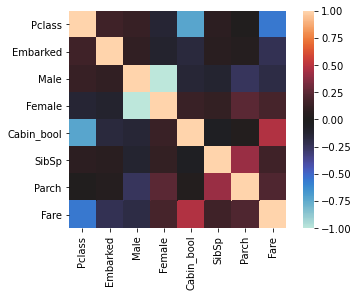

In [165]:
# Фич много, явно корелируют между собой
# Поэтому надо смотреть на кореляцию фич.

from seaborn import heatmap

heatmap(data[features].corr(), center=0, square=True)
plt.show()
# ИСКУССТВО!

In [183]:
# Больше пайплайнов богу пайплайнов
# идея взята из стать https://mahmoudyusof.github.io/general/scikit-learn-pipelines/
#  её ещё во время прошлой домашки кидал в материалы в дискорд


# Создаём обработчики фич, что не добил руками, то сделают эти ребята
categorical_pipeline = Pipeline([
    ("encoder", OneHotEncoder(sparse=True, handle_unknown="ignore"))
])

numerical_pipeline = Pipeline([
    ("scaler", StandardScaler())
])


# Создаю мегатрона, который будет применять обработчики фич выше 
# для обпеределённых фич
preprocessing_pipeline = ColumnTransformer([
    ("ordinal_preprocessor", categorical_pipeline, cat_features),
    ("numerical_preprocessor", numerical_pipeline, num_features)
])


## LogisticRegression

In [172]:


# По итогу получаем "мощную".. кхе-кхе... МОДЕЛЬ логрега.
logreg_model = Pipeline([
    ("preprocessor", preprocessing_pipeline),
    ("estimator", LogisticRegression(solver='liblinear', penalty='l2'))
])

Ну что, дальше по старинке, обучаем тестим и т.д.

In [173]:
logreg_model.fit(X_train, y_train)
# Получаем красивую схему, можно потискать!

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ordinal_preprocessor',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Embarked', 'Male',
                                                   'Female', 'Cabin_bool']),
                                                 ('numerical_preprocessor',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['SibSp', 'Parch',
                                                   'Fare'])])),
                ('estimator', LogisticRegression(solver='liblinear'))])

In [174]:
# кросс-валидируем train
logreg_train_cv = cross_val_score(logreg_model, X_train, y_train,
                      scoring='accuracy', cv=5).mean()
print("CV on X_train: ", logreg_train_cv)
# Ах, этот скор, да на kaggle

CV on X_train:  0.8105935483870969


In [191]:
# кросс-валидируем test
logreg_test_cv = cross_val_score(logreg_model, X_test, y_test,
                      scoring='accuracy', cv=5).mean()
print("CV on X_test: ", logreg_test_cv)
# Ах, тут всё грустнее и больше похоже на правду, 
# видимо где-то overfitting

CV on X_test:  0.8025856044723969


In [176]:
# Чтож, мне аж захотелось снова отправить файл на кагл! и это в 5:30 утра
logreg_model.fit(X, y)

kaggle_logreg_pred =  logreg_model.predict(test[features])

In [181]:
# Используем свою функцию для создания файла ответа
create_csv(logreg_model["estimator"], 
           kaggle_test_predict_log, 
           "LogReg_L2_MAXTUNE",
          cv_train = logreg_train_cv, 
          cv_test = logreg_test_cv)

COMMENT FOR KAGGLE
LogisticRegression(solver='liblinear')
['Pclass', 'Embarked', 'Male', 'Female', 'Cabin_bool', 'SibSp', 'Parch', 'Fare']
CV on X_train:  0.8105935483870969
CV on X_test:  0.8025856044723969


Один вопрос: **ЗА ЧТООО????**
Возможно если поперебирать фичи можно будет улучшить результат, но надо заканчивать этот ноутбук и лить на гитхаб. Но пожалуй я попробую еще в KNN на максималках
![title](https://sun9-46.userapi.com/impf/PndJ-c-qhXnpPZ2oGoU_gBQikE2hO56hmaveEA/rKt5GT41-a0.jpg?size=962x230&quality=96&sign=cd226e3fb5ab315be27b961a2a6bb233&type=album)

---
---


## KNN

Вся обработка фич и препроцессинг есть выше, поэтому нам остаётся только создать модельку, обучить и отправить результаты на кагл. Чтож, удачи мне!

In [220]:
knn_model = Pipeline([
    ("preprocessor", preprocessing_pipeline),
    ("estimator", KNeighborsClassifier(n_neighbors = 11,  weights='distance'))
])


In [221]:
knn_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ordinal_preprocessor',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Embarked', 'Male',
                                                   'Female', 'Cabin_bool']),
                                                 ('numerical_preprocessor',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['SibSp', 'Parch',
                                                   'Fare'])])),
                ('estimator',
                 KNeighborsClassifier(n_neighbors=11, weights='distance'))])

In [222]:
knn_train_cv = cross_val_score(knn_model, X_train, y_train,
                      scoring='accuracy', cv=5).mean()

print("CV on X_train: ", knn_train_cv)

CV on X_train:  0.7882322580645162


In [223]:
knn_test_cv = cross_val_score(knn_model, X_test, y_test,
                      scoring='accuracy', cv=5).mean()

print("CV on X_test: ", knn_test_cv)

CV on X_test:  0.780083857442348


In [224]:
knn_model.fit(X, y)

kaggle_knn_pred =  knn_model.predict(test[features])

In [225]:
# Время новой боли... или нет?
create_csv(knn_model["estimator"], 
           kaggle_knn_pred, 
           "KNN_11_MAXTUNE",
          cv_train = knn_train_cv, 
          cv_test = knn_test_cv)

COMMENT FOR KAGGLE
KNeighborsClassifier(n_neighbors=11, weights='distance')
['Pclass', 'Embarked', 'Male', 'Female', 'Cabin_bool', 'SibSp', 'Parch', 'Fare']
CV on X_train:  0.7882322580645162
CV on X_test:  0.780083857442348


Я ожидал чего-то такого, но такого я не ожидал.
![title](https://sun9-10.userapi.com/impf/G9BY8X9V8G1EzmulrTDiWEpe1xpelgPcMrQUyw/PJowjoh76cI.jpg?size=973x226&quality=96&sign=5fc82eec51b7f40129a6858750e2fbcb&type=album)

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

![title](https://sun9-64.userapi.com/impf/aBKx2rRHXcQjzwdsPTWr8CVdInOUbRfL5Gm7AQ/JKUs-KtwVUA.jpg?size=977x138&quality=96&sign=729af66d1f793d9a8a7ba0acb94eadd5&type=album)

_По итогу лучший счёт на kaggle, выбитый практически сразу и недостижимый в последующем оказался 0.77511. 
Итого 0.5 + 0.5 = 1 бал._

Текущую позицию в leaderboard kaggle можно узнать по ссылке https://www.kaggle.com/jacknightsky/competitions?sortBy=best&group=entered&page=1&pageSize=20

Данные для связи:
- discord: @JackNightsky#1811
- github: JackNightsky